In [85]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import cv2
from tqdm import tqdm

In [86]:
df = pd.read_csv("../data/HAM10000_metadata.csv")

In [87]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [88]:
df.dx_type

0        histo
1        histo
2        histo
3        histo
4        histo
         ...  
10010    histo
10011    histo
10012    histo
10013    histo
10014    histo
Name: dx_type, Length: 10015, dtype: object

In [89]:
df.dx.value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

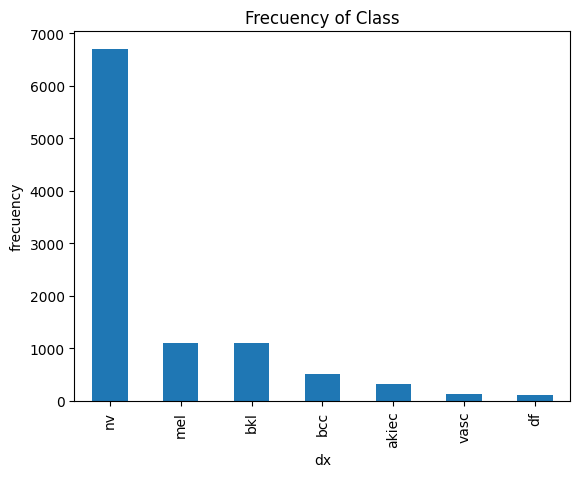

In [90]:
df.dx.value_counts().plot(kind="bar", title="Frecuency of Class", ylabel="frecuency")
plt.show()

In [91]:
# Reading the data
path = '../data'
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(path,'*','*.jpg'))}

In [92]:
len(images_path)

10015

In [93]:
images_path

{'ISIC_0026784': '../data/HAM10000_images_part_1/ISIC_0026784.jpg',
 'ISIC_0028971': '../data/HAM10000_images_part_1/ISIC_0028971.jpg',
 'ISIC_0026948': '../data/HAM10000_images_part_1/ISIC_0026948.jpg',
 'ISIC_0026790': '../data/HAM10000_images_part_1/ISIC_0026790.jpg',
 'ISIC_0028965': '../data/HAM10000_images_part_1/ISIC_0028965.jpg',
 'ISIC_0025299': '../data/HAM10000_images_part_1/ISIC_0025299.jpg',
 'ISIC_0024839': '../data/HAM10000_images_part_1/ISIC_0024839.jpg',
 'ISIC_0024811': '../data/HAM10000_images_part_1/ISIC_0024811.jpg',
 'ISIC_0026960': '../data/HAM10000_images_part_1/ISIC_0026960.jpg',
 'ISIC_0028795': '../data/HAM10000_images_part_1/ISIC_0028795.jpg',
 'ISIC_0026974': '../data/HAM10000_images_part_1/ISIC_0026974.jpg',
 'ISIC_0028781': '../data/HAM10000_images_part_1/ISIC_0028781.jpg',
 'ISIC_0028959': '../data/HAM10000_images_part_1/ISIC_0028959.jpg',
 'ISIC_0024805': '../data/HAM10000_images_part_1/ISIC_0024805.jpg',
 'ISIC_0025528': '../data/HAM10000_images_part_1

In [94]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'

}

In [95]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,9958.0,51.863828,16.968614,0.0,40.0,50.0,65.0,85.0


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [97]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [98]:
# Adding extra columns and appending the required created columns in final dataframe
df['path'] = df['image_id'].map(images_path.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [99]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [100]:
# resize input images
IMAGE_SIZE = 288

In [101]:
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img

In [102]:
df.path.values

array(['../data/HAM10000_images_part_1/ISIC_0027419.jpg',
       '../data/HAM10000_images_part_1/ISIC_0025030.jpg',
       '../data/HAM10000_images_part_1/ISIC_0026769.jpg', ...,
       '../data/HAM10000_images_part_2/ISIC_0033536.jpg',
       '../data/HAM10000_images_part_2/ISIC_0032854.jpg',
       '../data/HAM10000_images_part_2/ISIC_0032258.jpg'], dtype=object)

In [103]:
import shutil

In [104]:
BASE_DATASET_DIR = "dataset"

for src_path, img_class in zip(df.path.values, df.cell_type.values):
  to_images_path = os.path.join(BASE_DATASET_DIR, img_class)

  if not os.path.exists(to_images_path):
    os.mkdir(to_images_path)

  shutil.copy(src_path, to_images_path)

In [105]:
df.cell_type.value_counts()

cell_type
Melanocytic Nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64

In [106]:
new_df = df.copy()

In [107]:
new_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [108]:
new_df = new_df[["image_id", "path", "cell_type", "cell_type_idx"]]

In [109]:
new_df.head()

,image_id,path,cell_type,cell_type_idx
0,ISIC_0027419,../data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,ISIC_0025030,../data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,ISIC_0026769,../data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,ISIC_0025661,../data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,ISIC_0031633,../data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [110]:
new_df.cell_type.unique().tolist()

['Benign keratosis-like lesions ',
 'Melanocytic Nevi',
 'Dermatofibroma',
 'Melanoma',
 'Vascular lesions',
 'Basal cell carcinoma',
 'Actinic keratoses']

In [111]:
new_df = new_df.loc[~new_df.cell_type.isin(["Vascular lesions", "Dermatofibroma"])]

In [112]:
new_df.shape

(9758, 4)

In [113]:
new_df.cell_type.value_counts()

cell_type
Melanocytic Nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Name: count, dtype: int64

In [114]:
balanced_size = new_df.cell_type.value_counts()["Actinic keratoses"]

In [115]:
new_df.loc[new_df.cell_type == "Melanocytic Nevi"].sample(n=balanced_size, replace=False)

,image_id,path,cell_type,cell_type_idx
5893,ISIC_0027286,../data/HAM10000_images_part_1/ISIC_0027286.jpg,Melanocytic Nevi,4
3839,ISIC_0032263,../data/HAM10000_images_part_2/ISIC_0032263.jpg,Melanocytic Nevi,4
8232,ISIC_0030597,../data/HAM10000_images_part_2/ISIC_0030597.jpg,Melanocytic Nevi,4
7658,ISIC_0033665,../data/HAM10000_images_part_2/ISIC_0033665.jpg,Melanocytic Nevi,4
9138,ISIC_0032074,../data/HAM10000_images_part_2/ISIC_0032074.jpg,Melanocytic Nevi,4
...,...,...,...,...
6420,ISIC_0030952,../data/HAM10000_images_part_2/ISIC_0030952.jpg,Melanocytic Nevi,4
8856,ISIC_0025655,../data/HAM10000_images_part_1/ISIC_0025655.jpg,Melanocytic Nevi,4
7621,ISIC_0032689,../data/HAM10000_images_part_2/ISIC_0032689.jpg,Melanocytic Nevi,4
7326,ISIC_0032743,../data/HAM10000_images_part_2/ISIC_0032743.jpg,Melanocytic Nevi,4


In [116]:
for c_type in new_df.cell_type.unique():
  if c_type != "Actinic keratoses":
    print("cell type pick: ", c_type)
    c_type_df = new_df[new_df.cell_type == c_type]
    dropped_df = c_type_df.loc[~c_type_df.index.isin(new_df[new_df.cell_type == c_type].sample(n=balanced_size, replace=False, random_state=42).index)]
    new_df.drop(dropped_df.index, inplace=True)

cell type pick:  Benign keratosis-like lesions 
cell type pick:  Melanocytic Nevi
cell type pick:  Melanoma
cell type pick:  Basal cell carcinoma


In [117]:
new_df.cell_type.value_counts()

cell_type
Benign keratosis-like lesions     327
Melanoma                          327
Basal cell carcinoma              327
Melanocytic Nevi                  327
Actinic keratoses                 327
Name: count, dtype: int64

In [118]:
new_df.reset_index()

,index,image_id,path,cell_type,cell_type_idx
0,2,ISIC_0026769,../data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
1,3,ISIC_0025661,../data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
2,6,ISIC_0029176,../data/HAM10000_images_part_1/ISIC_0029176.jpg,Benign keratosis-like lesions,2
3,10,ISIC_0025276,../data/HAM10000_images_part_1/ISIC_0025276.jpg,Benign keratosis-like lesions,2
4,12,ISIC_0025984,../data/HAM10000_images_part_1/ISIC_0025984.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...
1630,10009,ISIC_0031430,../data/HAM10000_images_part_2/ISIC_0031430.jpg,Actinic keratoses,0
1631,10010,ISIC_0033084,../data/HAM10000_images_part_2/ISIC_0033084.jpg,Actinic keratoses,0
1632,10011,ISIC_0033550,../data/HAM10000_images_part_2/ISIC_0033550.jpg,Actinic keratoses,0
1633,10012,ISIC_0033536,../data/HAM10000_images_part_2/ISIC_0033536.jpg,Actinic keratoses,0


<Axes: xlabel='cell_type'>

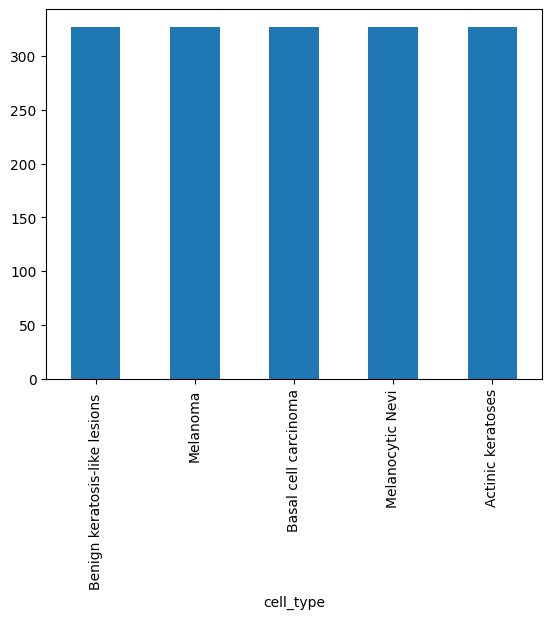

In [119]:
new_df.cell_type.value_counts().plot(kind="bar")

In [120]:
new_df.to_csv("HAM_327.csv", index=False)

In [121]:
balance_ds = pd.read_csv("HAM_327.csv")

In [122]:
balance_ds.head()

,image_id,path,cell_type,cell_type_idx
0,ISIC_0026769,../data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
1,ISIC_0025661,../data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
2,ISIC_0029176,../data/HAM10000_images_part_1/ISIC_0029176.jpg,Benign keratosis-like lesions,2
3,ISIC_0025276,../data/HAM10000_images_part_1/ISIC_0025276.jpg,Benign keratosis-like lesions,2
4,ISIC_0025984,../data/HAM10000_images_part_1/ISIC_0025984.jpg,Benign keratosis-like lesions,2


In [123]:
BASE_DATASET_DIR = "dataset_v2"

if not os.path.exists(BASE_DATASET_DIR):
  os.mkdir(BASE_DATASET_DIR)

for src_path, img_class in zip(balance_ds.path.values, balance_ds.cell_type.values):
  to_images_path = os.path.join(BASE_DATASET_DIR, img_class)

  if not os.path.exists(to_images_path):
    os.mkdir(to_images_path)

  shutil.copy(src_path, to_images_path)

In [124]:
balance_ds.cell_type.value_counts()

cell_type
Benign keratosis-like lesions     327
Melanoma                          327
Basal cell carcinoma              327
Melanocytic Nevi                  327
Actinic keratoses                 327
Name: count, dtype: int64

In [125]:
import tensorflow as tf
import numpy as np

In [126]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset_v2",
    batch_size=8,
    image_size=(228, 228),
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="both",
    labels="inferred",
    label_mode="categorical"
)

Found 1635 files belonging to 5 classes.


Using 1145 files for training.
Using 490 files for validation.


In [127]:
# amount of batch
len(train_ds), len(val_ds)

(144, 62)

In [128]:
train_ds.class_names

['Actinic keratoses',
 'Basal cell carcinoma',
 'Benign keratosis-like lesions ',
 'Melanocytic Nevi',
 'Melanoma']

In [129]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [130]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00055000786 0.79066163


In [131]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [132]:
def create_model(base, num_class):
  inputs = tf.keras.Input(shape=(228,228,3))
  # x = tf.keras.layers.Rescaling(1./255)(inputs)
  # x = tf.keras.layers.RandomFlip('horizontal')(inputs)
  # x = tf.keras.applications.efficientnet.preprocess_input(x)
  x = base(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.BatchNormalization()(x)
  outputs = tf.keras.layers.Dense(num_class, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  return model

In [133]:
# Load the pre-trained model
eff_net = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(228, 228, 3))

# Freeze the pre-trained model
eff_net.trainable = False

model = create_model(eff_net, 5)

# Compile the model
model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])

In [134]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 228, 228, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_97 (Ba  (None, 1280)              5120      
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 5)                 6405      
                                                           

In [135]:
history_effnet = model.fit(train_ds, epochs=10, steps_per_epoch=len(train_ds), validation_data=val_ds)

Epoch 1/10


144/144 [==============================] - 25s 155ms/step - loss: 1.5178 - accuracy: 0.4087 - val_loss: 1.2955 - val_accuracy: 0.4694
Epoch 2/10
144/144 [==============================] - 20s 142ms/step - loss: 1.0086 - accuracy: 0.6131 - val_loss: 1.1839 - val_accuracy: 0.5367
Epoch 3/10
144/144 [==============================] - 21s 144ms/step - loss: 0.8086 - accuracy: 0.7039 - val_loss: 1.1547 - val_accuracy: 0.5653
Epoch 4/10
144/144 [==============================] - 22s 150ms/step - loss: 0.6712 - accuracy: 0.7651 - val_loss: 1.1602 - val_accuracy: 0.5735
Epoch 5/10
144/144 [==============================] - 22s 152ms/step - loss: 0.5677 - accuracy: 0.8122 - val_loss: 1.1651 - val_accuracy: 0.6000
Epoch 6/10
144/144 [==============================] - 23s 159ms/step - loss: 0.4861 - accuracy: 0.8515 - val_loss: 1.1670 - val_accuracy: 0.6163
Epoch 7/10
144/144 [==============================] - 24s 165ms/step - loss: 0.4199 - accuracy: 0.8865 - val_loss: 1.1712 - val_accuracy: 0.6

In [162]:
total_accuracy = 7.8472
total_loss = 6.4442
num_batches = 8

# Hitung rata-rata akurasi dan loss
average_accuracy = (total_accuracy / num_batches)
average_loss = (total_loss / num_batches)

print("Average Accuracy:", average_accuracy)
print("Average Loss:", average_loss)

Average Accuracy: 0.9809
Average Loss: 0.805525


In [136]:
# Load the pre-trained model
inception = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_shape=(228, 228, 3))

# Freeze the pre-trained model
inception.trainable = False

model = create_model(inception, 5)

# Compile the model
model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])

In [137]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 228, 228, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_192 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dense_14 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 21821221 (83.24 MB)
Trainable params: 14341 (

In [138]:
history_inception = model.fit(train_ds, epochs=10, steps_per_epoch=len(train_ds), validation_data=val_ds)

Epoch 1/10


144/144 [==============================] - 45s 300ms/step - loss: 1.6964 - accuracy: 0.3843 - val_loss: 2.2668 - val_accuracy: 0.3245
Epoch 2/10
144/144 [==============================] - 45s 311ms/step - loss: 1.3765 - accuracy: 0.4751 - val_loss: 1.7397 - val_accuracy: 0.4082
Epoch 3/10
144/144 [==============================] - 43s 299ms/step - loss: 1.2225 - accuracy: 0.5380 - val_loss: 1.7259 - val_accuracy: 0.4327
Epoch 4/10
144/144 [==============================] - 44s 303ms/step - loss: 1.1054 - accuracy: 0.5782 - val_loss: 1.7626 - val_accuracy: 0.4347
Epoch 5/10
144/144 [==============================] - 44s 309ms/step - loss: 1.0113 - accuracy: 0.6166 - val_loss: 1.8025 - val_accuracy: 0.4245
Epoch 6/10
144/144 [==============================] - 44s 309ms/step - loss: 0.9323 - accuracy: 0.6428 - val_loss: 1.8399 - val_accuracy: 0.4265
Epoch 7/10
144/144 [==============================] - 44s 307ms/step - loss: 0.8649 - accuracy: 0.6812 - val_loss: 1.8760 - val_accuracy: 0.4

In [163]:
total_accuracy = 6.1441
total_loss = 10.4847
num_batches = 8

# Hitung rata-rata akurasi dan loss
average_accuracy = (total_accuracy / num_batches)
average_loss = (total_loss / num_batches)

print("Average Accuracy:", average_accuracy)
print("Average Loss:", average_loss)

Average Accuracy: 0.7680125
Average Loss: 1.3105875


In [152]:
from keras.models import Sequential, model_from_json, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D

In [158]:
0#Keras Sequential API
#CNN Model: Conv x2 -> MaxPool -> Dropout -> Conv x2 -> MaxPool -> Dropout -> Flatten -> Dense -> Dropout -> Dense 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same', input_shape=(228, 228, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(GlobalAveragePooling2D(keepdims=True))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(GlobalAveragePooling2D(keepdims=True))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])

In [150]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_212 (Conv2D)         (None, 228, 228, 32)      896       
                                                                 
 conv2d_213 (Conv2D)         (None, 228, 228, 32)      9248      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 114, 114, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 114, 114, 32)      0         
                                                                 
 conv2d_214 (Conv2D)         (None, 114, 114, 64)      18496     
                                                                 
 conv2d_215 (Conv2D)         (None, 114, 114, 64)      36928     
                                                      

In [146]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [143]:
import matplotlib.pyplot as plt


def plot_hist_incep(hist):
    plt.plot(hist.history_inception["accuracy"])
    plt.plot(hist.history_inception["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

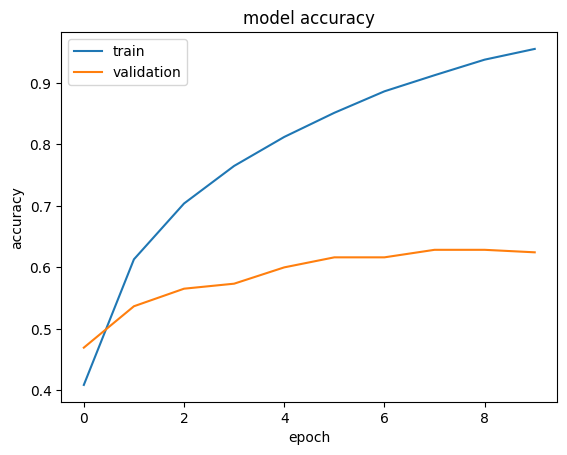

In [147]:
plot_hist(history_effnet)

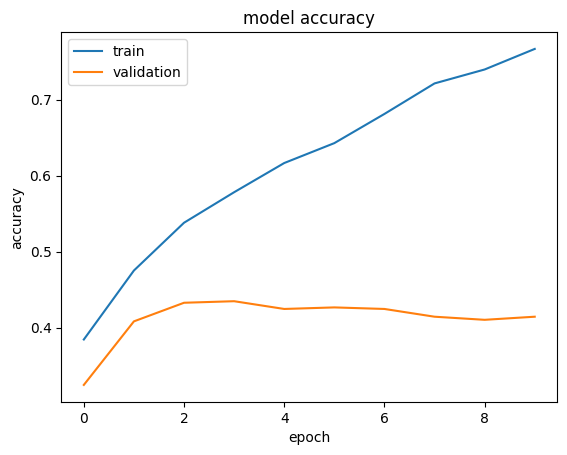

In [148]:
plot_hist(history_inception)